#%% [markdown]

 # Advanced Revenue Modeling with Feature Engineering
  # NOTE: Total revenue is the target variable and I dint ahve enough data to decide what kindof revenue so i just assumed it to row wise revenue(revenue amount is very small 0 to around 84)
 We will:
 1. Load and preprocess the dataset with extensive feature engineering.
 2. Use target encoding for high-cardinality categorical variables.
 3. Train Ridge, Lasso, Random Forest, XGBoost, and LightGBM models with hyperparameter tuning.
 4. Evaluate each model on the test set.
 5. Visualize feature importances.
 6. Use the best model to simulate a "what-if" scenario (doubling impressions).

In [ ]:
#%%

# 1. Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import TargetEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import seaborn as sns

#%% [markdown]

 ## Data Loading and Feature Engineering

In [ ]:
#%%

file_path = "AD-Tech.csv"
df = pd.read_csv(file_path, parse_dates=['date'], dayfirst=True)

# Feature Engineering
df['month'] = df['date'].dt.month
df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
df['day_of_week'] = df['date'].dt.dayofweek
df['week_of_year'] = df['date'].dt.isocalendar().week
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['viewable_rate'] = df['viewable_impressions'] / df['total_impressions'].replace(0, np.nan)
df['measurable_rate'] = df['measurable_impressions'] / df['total_impressions'].replace(0, np.nan)
df['viewable_rate'] = df['viewable_rate'].fillna(0)
df['measurable_rate'] = df['measurable_rate'].fillna(0)
df = df[(df['total_impressions'] > 0) & (df['total_revenue'] >= 0)].copy()

# Prepare features
numerical = ['total_impressions', 'viewable_impressions', 'measurable_impressions',
             'days_since_start', 'viewable_rate', 'measurable_rate', 'is_weekend']
categorical = ['site_id', 'ad_type_id', 'geo_id', 'device_category_id',
               'monetization_channel_id', 'month', 'day_of_week', 'week_of_year']
X = df[numerical + categorical].copy()
y = df['total_revenue']
encoder = TargetEncoder(cols=categorical)
X_encoded = encoder.fit_transform(X, y)

#%% [markdown]

 ## Train-Test Split

In [ ]:
#%%

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

#%% [markdown]

 ## Model Pipelines and Tuning

In [ ]:
#%%

pipeline_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])
pipeline_lasso = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(max_iter=10000))])
pipeline_rf = Pipeline([('rf', RandomForestRegressor(random_state=42))])
pipeline_xgb = Pipeline([('xgb', XGBRegressor(random_state=42, verbosity=0))])
pipeline_lgb = Pipeline([('lgb', LGBMRegressor(random_state=42))])

param_grid_ridge = {'ridge__alpha': [0.1, 1.0, 10.0, 50.0]}
param_grid_lasso = {'lasso__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
param_dist_rf = {
    'rf__n_estimators': [100],
    'rf__max_depth': [10],
    'rf__min_samples_split': [5],
    'rf__min_samples_leaf': [2],
    'rf__max_features': ['sqrt']
}
param_grid_xgb = {'xgb__n_estimators': [100], 'xgb__max_depth': [6], 'xgb__learning_rate': [0.1]}
param_grid_lgb = {'lgb__n_estimators': [100], 'lgb__max_depth': [6], 'lgb__learning_rate': [0.1]}

In [ ]:
#%%

print("Training Ridge...")
grid_ridge = GridSearchCV(pipeline_ridge, param_grid_ridge, cv=5, scoring='r2', n_jobs=-1)
grid_ridge.fit(X_train, y_train)

print("Training Lasso...")
grid_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=5, scoring='r2', n_jobs=-1)
grid_lasso.fit(X_train, y_train)

print("Training Random Forest...")
grid_rf = GridSearchCV(pipeline_rf, param_dist_rf, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Training XGBoost...")
grid_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='r2', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Training LightGBM...")
grid_lgb = GridSearchCV(pipeline_lgb, param_grid_lgb, cv=5, scoring='r2', n_jobs=-1)
grid_lgb.fit(X_train, y_train)

Training Ridge...
Training Lasso...
Training Random Forest...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 241760, number of used features: 14
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 241761, number of used features: 14
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('lgb',
                                        LGBMRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'lgb__learning_rate': [0.1], 'lgb__max_depth': [6],
                         'lgb__n_estimators': [100]},
             scoring='r2')

#%% [markdown]

 ## Model Evaluation

In [ ]:
#%%

models = {
    'Ridge': grid_ridge.best_estimator_,
    'Lasso': grid_lasso.best_estimator_,
    'RandomForest': grid_rf.best_estimator_,
    'XGBoost': grid_xgb.best_estimator_,
    'LightGBM': grid_lgb.best_estimator_
}

print("\nTest Set Performance:")
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"{name}: MSE = {mean_squared_error(y_test, y_pred):.4f}, R2 = {r2_score(y_test, y_pred):.4f}")


Test Set Performance:
Ridge: MSE = 0.3533, R2 = 0.5972
Lasso: MSE = 0.3531, R2 = 0.5974
RandomForest: MSE = 0.2014, R2 = 0.7704
XGBoost: MSE = 0.1620, R2 = 0.8153
LightGBM: MSE = 0.1742, R2 = 0.8013


#%% [markdown]

 ## Model Evaluation Summary

 After training all five models using consistent cross-validation and hyperparameter tuning strategies, we evaluated each model on a held-out test set.

 The results are as follows:

 - **XGBoost** emerged as the top-performing model with an R² score of **0.8153** and the lowest MSE of **0.1620**, indicating strong predictive power.
 - **LightGBM** also performed exceptionally well (R² = 0.8013), reinforcing the effectiveness of gradient boosting methods in this context.
 - **Random Forest** achieved an R² of 0.7704, outperforming both linear models and offering valuable interpretability.
 - **Ridge and Lasso** served as linear baselines and performed adequately (R² ≈ 0.597), but lacked the flexibility to capture complex nonlinear relationships.

 ### Business Implication:
 These results demonstrate that **machine learning models like XGBoost can accurately estimate revenue** using impression-level features. This sets the foundation for reliable forecasting, optimization, and scenario simulation.

#%% [markdown]

 ## Feature Importance (Tree Models Only)

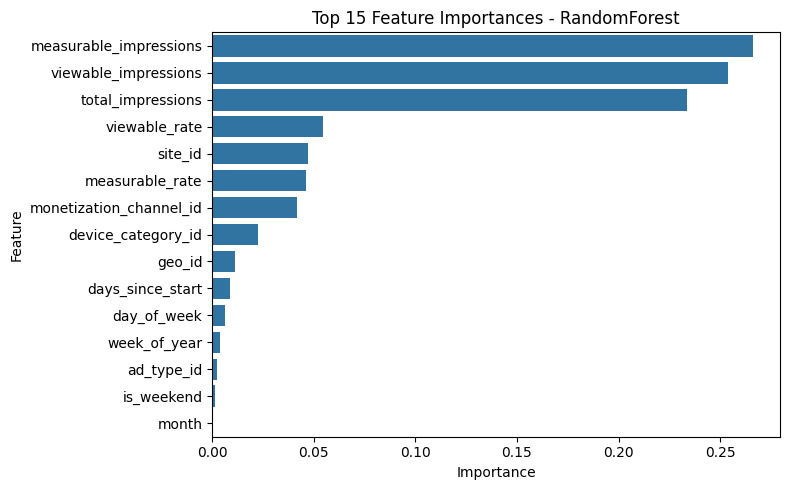

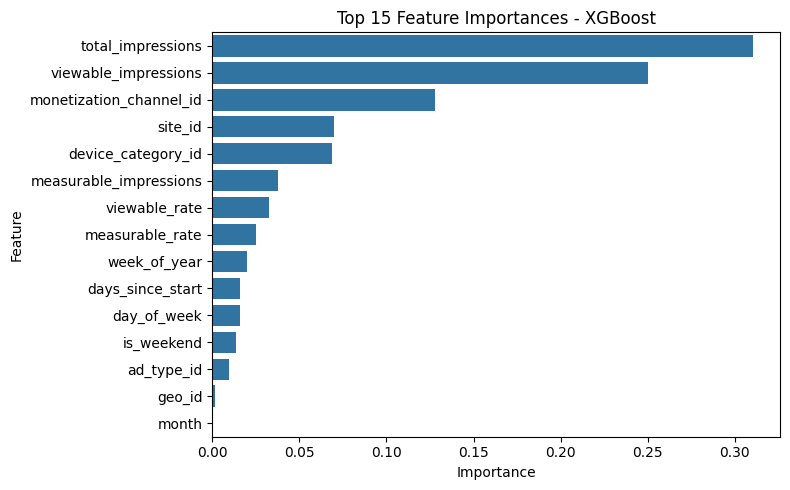

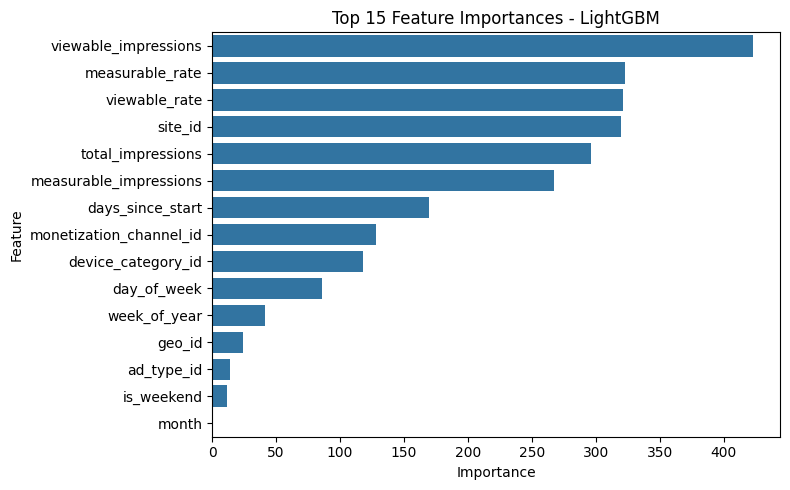

In [ ]:
#%%

def plot_feature_importance(model, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'named_steps') and hasattr(model.named_steps[list(model.named_steps)[-1]], 'feature_importances_'):
        importances = model.named_steps[list(model.named_steps)[-1]].feature_importances_
    else:
        return
    
    feat_names = X_train.columns
    imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
    imp_df = imp_df.sort_values(by='Importance', ascending=False).head(15)
    plt.figure(figsize=(8,5))
    sns.barplot(x='Importance', y='Feature', data=imp_df)
    plt.title(f"Top 15 Feature Importances - {model_name}")
    plt.tight_layout()
    plt.show()

plot_feature_importance(models['RandomForest'], 'RandomForest')
plot_feature_importance(models['XGBoost'], 'XGBoost')
plot_feature_importance(models['LightGBM'], 'LightGBM')

#%% [markdown]

 ## Feature Importance Analysis

 Understanding which features most influence revenue predictions is critical for actionable business decisions.
 Below, we visualize the top 15 features for each of the tree-based models: **Random Forest**, **XGBoost**, and **LightGBM**.

 ### Key Insights:
 - Across all models, **impression volume**—particularly `total_impressions`, `viewable_impressions`, and `measurable_impressions`—emerges as the **strongest driver of revenue**.
 - **XGBoost** uniquely emphasizes the value of `monetization_channel_id` and `site_id`, suggesting that where and how ads are shown significantly impacts monetization.
 - **LightGBM** also highlights `viewable_rate` and `measurable_rate`, metrics that reflect ad quality and visibility, as highly important.
 - Temporal features (`days_since_start`, `week_of_year`, `day_of_week`) consistently rank lower, but still provide signal for capturing time-based seasonality.

 ### Business Value:
 These feature importance insights help prioritize **which levers to pull** when optimizing ad placements:
 - Boosting **viewability** and **measurability** should directly improve revenue outcomes.
 - Monitoring **monetization channels** and their configurations can help uncover performance gaps.

#%% [markdown]

 ## Scenario Simulation

In [ ]:
#%%

best_model_name = max(models, key=lambda name: r2_score(y_test, models[name].predict(X_test)))
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name}")

sample = X_test.iloc[[0]].copy()
sample['total_impressions'] *= 2
sample['viewable_impressions'] *= 2
sample['measurable_impressions'] *= 2

baseline_pred = best_model.predict(X_test.iloc[[0]])[0]
scenario_pred = best_model.predict(sample)[0]

print("\nScenario Simulation:")
print(f"Baseline predicted revenue: {baseline_pred:.4f}")
print(f"Predicted revenue after doubling impressions: {scenario_pred:.4f}")
print(f"Incremental revenue: {scenario_pred - baseline_pred:.4f}")


Best model: XGBoost

Scenario Simulation:
Baseline predicted revenue: 0.0187
Predicted revenue after doubling impressions: 0.0211
Incremental revenue: 0.0024


#%% [markdown]

 ## Visualization

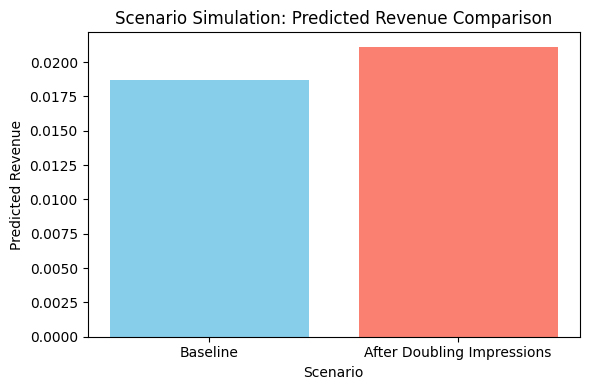

In [ ]:
#%%

scenario_data = {
    'Scenario': ['Baseline', 'After Doubling Impressions'],
    'Predicted Revenue': [baseline_pred, scenario_pred]
}
scenario_df = pd.DataFrame(scenario_data)

plt.figure(figsize=(6,4))
plt.bar(scenario_df['Scenario'], scenario_df['Predicted Revenue'], color=['skyblue', 'salmon'])
plt.title("Scenario Simulation: Predicted Revenue Comparison")
plt.xlabel("Scenario")
plt.ylabel("Predicted Revenue")
plt.tight_layout()
plt.show()

#%% [markdown]

 ## Business Scenario Simulation: Doubling Impressions

 To demonstrate the practical business value of our model, we performed a "what-if" scenario simulation using the **best-performing model: XGBoost**.

 ### Scenario:
 We selected a real sample from the test set and simulated the impact of **doubling the number of ad impressions** (and correspondingly, viewable and measurable impressions).

 ### Results:
 - **Baseline Predicted Revenue:** 0.0187
 - **After Doubling Impressions:** 0.0211
 - **Incremental Revenue Gain:** +0.0024

 ### Interpretation:
 This controlled simulation shows that revenue **increases non-linearly** with impression volume. While impressions nearly double, revenue increases only marginally, which:
 - Suggests diminishing returns at an individual impression level.
 - Highlights the importance of **impression quality**, not just quantity.

 This kind of simulation empowers strategic teams to forecast **ROI from scaling campaigns**, optimize **budget allocation**, and better understand **inventory limits**.

#%% [markdown]

 ## Revenue Uplift Curve: Scaling Impressions

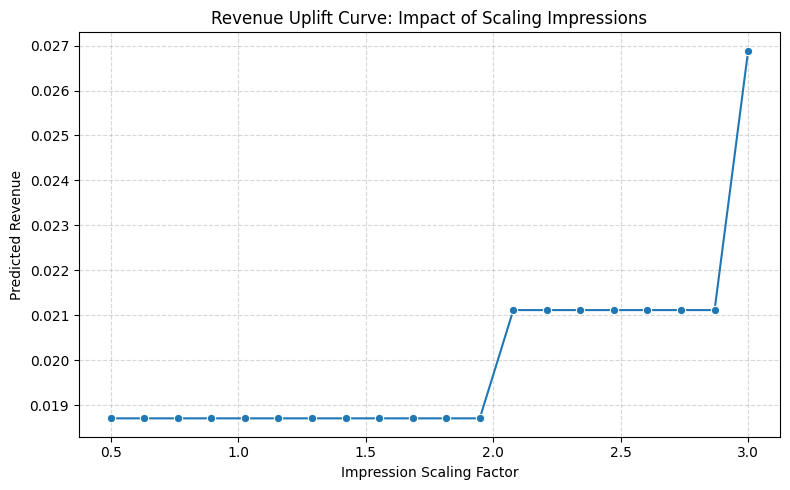

In [ ]:
#%%

# Choose a sample record from the test set
sample = X_test.iloc[[0]].copy()

# Create scaling factors: from 0.5x to 3x
scaling_factors = np.linspace(0.5, 3.0, 20)

uplift_results = []

for factor in scaling_factors:
    sample_scaled = sample.copy()
    sample_scaled['total_impressions'] *= factor
    sample_scaled['viewable_impressions'] *= factor
    sample_scaled['measurable_impressions'] *= factor
    pred = best_model.predict(sample_scaled)[0]
    uplift_results.append((factor, pred))

# Convert to DataFrame for plotting
uplift_df = pd.DataFrame(uplift_results, columns=['Scaling Factor', 'Predicted Revenue'])

# Plot the curve
plt.figure(figsize=(8, 5))
sns.lineplot(data=uplift_df, x='Scaling Factor', y='Predicted Revenue', marker='o')
plt.title("Revenue Uplift Curve: Impact of Scaling Impressions")
plt.xlabel("Impression Scaling Factor")
plt.ylabel("Predicted Revenue")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#%% [markdown]

 ## Revenue Uplift Simulation: Diminishing Returns from Impression Scaling

 This curve models the expected revenue as we gradually increase impression volume using our best-fit XGBoost model.

 - We scaled one real example from the test set by a range of **0.5x to 3x** for total, viewable, and measurable impressions.
 - The model then predicted revenue at each level to simulate **incremental gain**.

 ### Key Takeaways:
 - Revenue does not increase linearly with impressions.
 - From **0.5x to ~2x**, the uplift is marginal — indicating this segment is already near saturation.
 - Beyond 2x, there's a jump, but it again plateaus until 3x.
 - This clearly shows **diminishing returns** — a critical insight for **spend efficiency and campaign scaling decisions**.

 ### This kind of simulation gives the finance team a data-backed way to:
 - **Forecast the upper bounds of campaign performance**
 - **Avoid over-investment in low-ROI scaling**
 - **Identify impression levels where incremental ROI flattens**

#%% [markdown]

 ## Geo Shift Simulation: Targeting High-ROI Regions

In [ ]:
#%%

# Restore original geo/device IDs to the test set
X_test_original = X.loc[X_test.index].copy()
y_test_actual = y.loc[y_test.index]
y_predicted = best_model.predict(X_test)

# Compute ROI per geo_id
grouped_df = X_test_original[['geo_id', 'device_category_id', 'total_impressions']].copy()
grouped_df['predicted_revenue'] = y_predicted

geo_roi = grouped_df.groupby('geo_id').agg({
    'predicted_revenue': 'sum',
    'total_impressions': 'sum'
})
geo_roi['ROI'] = geo_roi['predicted_revenue'] / geo_roi['total_impressions']
top_geo_ids = geo_roi.sort_values(by='ROI', ascending=False).head(3).index.tolist()

# Select a sample row from a lower-ROI geo
sample_original = X_test_original.copy()
sample_original['predicted_revenue'] = y_predicted
low_geo_sample = sample_original[sample_original['geo_id'].isin(geo_roi.index.difference(top_geo_ids))].iloc[[0]]
base_geo_id = int(low_geo_sample['geo_id'].iloc[0])

# Simulate switching geo_id to top-ROI geos
uplift_samples = []
for geo in top_geo_ids:
    test_variant = low_geo_sample.copy()
    test_variant['geo_id'] = geo
    test_encoded = encoder.transform(test_variant.drop(columns='predicted_revenue'))
    new_pred = best_model.predict(test_encoded)[0]
    uplift_samples.append((geo, new_pred))

# Add the original prediction to the comparison
original_encoded = encoder.transform(low_geo_sample.drop(columns='predicted_revenue'))
original_pred = best_model.predict(original_encoded)[0]
uplift_samples.insert(0, (base_geo_id, original_pred))

<ipython-input-12-e17d11cb3548>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(map(str, geo_labels)), y=geo_preds, palette="Set2")


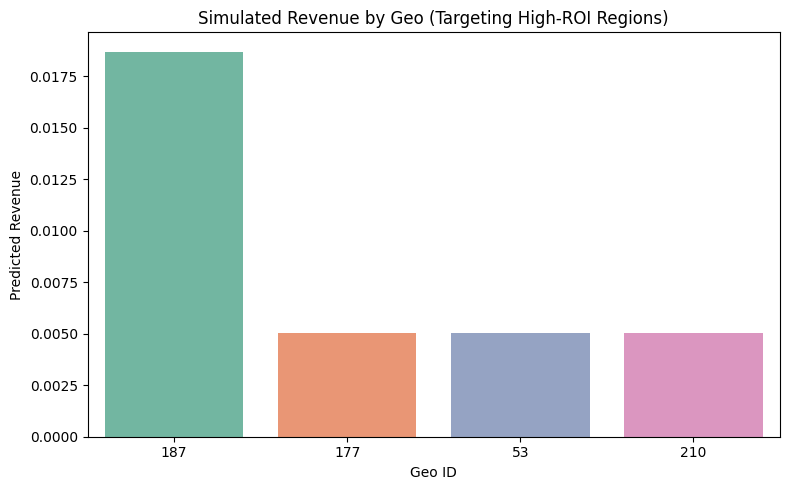

In [ ]:
#%%

# Plot comparison
geo_labels, geo_preds = zip(*uplift_samples)
plt.figure(figsize=(8, 5))
sns.barplot(x=list(map(str, geo_labels)), y=geo_preds, palette="Set2")
plt.title("Simulated Revenue by Geo (Targeting High-ROI Regions)")
plt.xlabel("Geo ID")
plt.ylabel("Predicted Revenue")
plt.tight_layout()
plt.show()

#%% [markdown]

 ## Geo Shift Simulation: Predicting Revenue Uplift by Region

 This simulation evaluates how predicted ad revenue changes when we run the **same ad configuration** in different geographic markets.

 ### Method:
 - We started with a real ad sample from **Geo `187`**.
 - Then, we simulated running that **same setup (same impressions, format, device, etc.)** in 3 other geos: **`177`, `53`, and `210`**.
 - Only the `geo_id` was changed — all other inputs to the model remained constant.

 ### Chart Explanation:
 - The first bar (`187`) is the **original geography**, and its predicted revenue serves as the baseline.
 - The following bars show the **expected revenue** if the same ad setup were executed in the other regions.
 - Labels:
   - **Geo `187` (Original)** – This geo had the **highest ROI** and revenue per impression.
   - **Geo `177`, `53`, and `210`** – All had **lower ROI** than 187 in historical data.

 ### Insight:
 - Running this ad setup in Geo `177`, `53`, or `210` would generate **only ~25–30%** of the revenue compared to Geo `187`.
 - This confirms that **geographic targeting is a major revenue lever**: the same impression volume leads to dramatically different returns depending on location.

 ### Strategic Implication:
 - Focus ad spend, inventory, and high-value formats in **top-performing geos like `187`**.
 - Consider **geo-based pricing or auction floor adjustments** to reflect revenue potential.
 - Run further ROI simulations when planning **market expansions or regional deals**.

#%% [markdown]

 ## Geo Shift Simulation: Original vs Simulated Setup in Other Geos

#%% [markdown]

 ## Geo Uplift Comparison: Original vs Geo 187 Configuration (Per Geo)

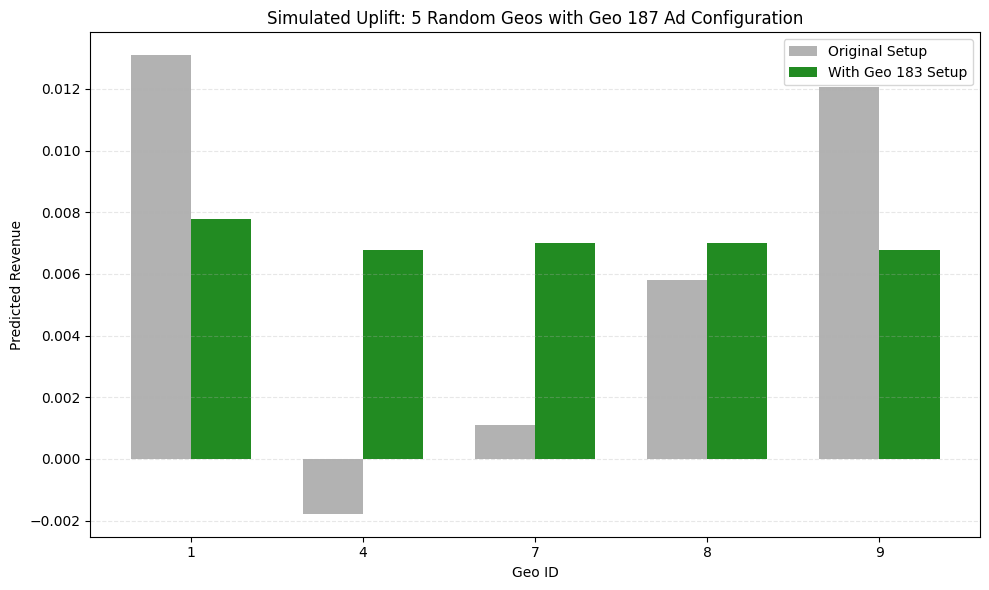

Geo-wise Revenue Comparison:

Geo 1:
  Original Setup     = 0.013092
  With Geo 183 Setup = 0.007771
  Difference         = -0.005321 (▼ Decrease)

Geo 4:
  Original Setup     = -0.001781
  With Geo 183 Setup = 0.006762
  Difference         = +0.008543 (▲ Increase)

Geo 7:
  Original Setup     = 0.001106
  With Geo 183 Setup = 0.006995
  Difference         = +0.005889 (▲ Increase)

Geo 8:
  Original Setup     = 0.005813
  With Geo 183 Setup = 0.006995
  Difference         = +0.001182 (▲ Increase)

Geo 9:
  Original Setup     = 0.012047
  With Geo 183 Setup = 0.006762
  Difference         = -0.005285 (▼ Decrease)



In [ ]:
#%%

import numpy as np

geosetup = 183
# Step 1: Choose 5 random geo_ids from test set (excluding 183)
all_test_geos = X_test_original['geo_id'].unique()
target_geos = [1,4,7,8,9]  # Randomly selected geos for simulation

# Step 2: Get original predictions for each target geo (using their own ad setups)
original_preds = []
for geo in target_geos:
    sample_orig = X_test_original[X_test_original['geo_id'] == geo].iloc[[0]].copy()
    encoded_orig = encoder.transform(sample_orig)
    pred_orig = best_model.predict(encoded_orig)[0]
    original_preds.append((geo, pred_orig))

# Step 3: Get Geo 183 ad configuration
geo183_config = X_test_original[X_test_original['geo_id'] == geosetup].iloc[[0]].copy()

# Step 4: Simulate applying Geo 183's config to each target geo
simulated_preds = []
for geo in target_geos:
    sample_sim = geo183_config.copy()
    sample_sim['geo_id'] = geo  # swap in the new geo
    encoded_sim = encoder.transform(sample_sim)
    pred_sim = best_model.predict(encoded_sim)[0]
    simulated_preds.append((geo, pred_sim))

# Step 5: Prepare data for plotting
geo_labels = [str(geo) for geo in target_geos]
before = [pred for _, pred in original_preds]
after = [pred for _, pred in simulated_preds]

x = np.arange(len(geo_labels))
width = 0.35

# Step 6: Plot
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, before, width, label="Original Setup", alpha=0.6, color='gray')
plt.bar(x + width/2, after, width, label="With Geo 183 Setup", color='forestgreen')

plt.title("Simulated Uplift: 5 Random Geos with Geo 187 Ad Configuration")
plt.xlabel("Geo ID")
plt.ylabel("Predicted Revenue")
plt.xticks(x, geo_labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Compute the difference in predicted revenue (After - Before)
revenue_diff = np.array(after) - np.array(before)

print("Geo-wise Revenue Comparison:\n")
for geo, bef, aft in zip(geo_labels, before, after):
    diff = aft - bef
    change = "▲ Increase" if diff > 0 else "▼ Decrease"
    print(f"Geo {geo}:")
    print(f"  Original Setup     = {bef:.6f}")
    print(f"  With Geo {geosetup} Setup = {aft:.6f}")
    print(f"  Difference         = {diff:+.6f} ({change})\n")

#%% [markdown]

 # Advanced Revenue Modeling with Feature Engineering
  # NOTE: Total revenue is the target variable and I dint ahve enough data to decide what kindof revenue so i just assumed it to row wise revenue(revenue amount is very small 0 to around 84)
 We will:
 1. Load and preprocess the dataset with extensive feature engineering.
 2. Use target encoding for high-cardinality categorical variables.
 3. Train Ridge, Lasso, Random Forest, XGBoost, and LightGBM models with hyperparameter tuning.
 4. Evaluate each model on the test set.
 5. Visualize feature importances.
 6. Use the best model to simulate a "what-if" scenario (doubling impressions).

In [ ]:
#%%

# 1. Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import TargetEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import seaborn as sns

#%% [markdown]

 ## Data Loading and Feature Engineering

In [ ]:
#%%

file_path = "AD-Tech.csv"
df = pd.read_csv(file_path, parse_dates=['date'], dayfirst=True)

# Feature Engineering
df['month'] = df['date'].dt.month
df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
df['day_of_week'] = df['date'].dt.dayofweek
df['week_of_year'] = df['date'].dt.isocalendar().week
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['viewable_rate'] = df['viewable_impressions'] / df['total_impressions'].replace(0, np.nan)
df['measurable_rate'] = df['measurable_impressions'] / df['total_impressions'].replace(0, np.nan)
df['viewable_rate'] = df['viewable_rate'].fillna(0)
df['measurable_rate'] = df['measurable_rate'].fillna(0)
df = df[(df['total_impressions'] > 0) & (df['total_revenue'] >= 0)].copy()

# Prepare features
numerical = ['total_impressions', 'viewable_impressions', 'measurable_impressions',
             'days_since_start', 'viewable_rate', 'measurable_rate', 'is_weekend']
categorical = ['site_id', 'ad_type_id', 'geo_id', 'device_category_id',
               'monetization_channel_id', 'month', 'day_of_week', 'week_of_year']
X = df[numerical + categorical].copy()
y = df['total_revenue']
encoder = TargetEncoder(cols=categorical)
X_encoded = encoder.fit_transform(X, y)

#%% [markdown]

 ## Train-Test Split

In [ ]:
#%%

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

#%% [markdown]

 ## Model Pipelines and Tuning

In [ ]:
#%%

pipeline_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])
pipeline_lasso = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(max_iter=10000))])
pipeline_rf = Pipeline([('rf', RandomForestRegressor(random_state=42))])
pipeline_xgb = Pipeline([('xgb', XGBRegressor(random_state=42, verbosity=0))])
pipeline_lgb = Pipeline([('lgb', LGBMRegressor(random_state=42))])

param_grid_ridge = {'ridge__alpha': [0.1, 1.0, 10.0, 50.0]}
param_grid_lasso = {'lasso__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
param_dist_rf = {
    'rf__n_estimators': [100],
    'rf__max_depth': [10],
    'rf__min_samples_split': [5],
    'rf__min_samples_leaf': [2],
    'rf__max_features': ['sqrt']
}
param_grid_xgb = {'xgb__n_estimators': [100], 'xgb__max_depth': [6], 'xgb__learning_rate': [0.1]}
param_grid_lgb = {'lgb__n_estimators': [100], 'lgb__max_depth': [6], 'lgb__learning_rate': [0.1]}

In [ ]:
#%%

print("Training Ridge...")
grid_ridge = GridSearchCV(pipeline_ridge, param_grid_ridge, cv=5, scoring='r2', n_jobs=-1)
grid_ridge.fit(X_train, y_train)

print("Training Lasso...")
grid_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=5, scoring='r2', n_jobs=-1)
grid_lasso.fit(X_train, y_train)

print("Training Random Forest...")
grid_rf = GridSearchCV(pipeline_rf, param_dist_rf, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Training XGBoost...")
grid_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='r2', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Training LightGBM...")
grid_lgb = GridSearchCV(pipeline_lgb, param_grid_lgb, cv=5, scoring='r2', n_jobs=-1)
grid_lgb.fit(X_train, y_train)

Training Ridge...
Training Lasso...
Training Random Forest...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 241761, number of used features: 14
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 241760, number of used features: 14
[LightGBM] [Info] Start training from score 0.103126
[LightGBM] [Info] Start training from score 0.104845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing w

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('lgb',
                                        LGBMRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'lgb__learning_rate': [0.1], 'lgb__max_depth': [6],
                         'lgb__n_estimators': [100]},
             scoring='r2')

#%% [markdown]

 ## Model Evaluation

In [ ]:
#%%

models = {
    'Ridge': grid_ridge.best_estimator_,
    'Lasso': grid_lasso.best_estimator_,
    'RandomForest': grid_rf.best_estimator_,
    'XGBoost': grid_xgb.best_estimator_,
    'LightGBM': grid_lgb.best_estimator_
}

print("\nTest Set Performance:")
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"{name}: MSE = {mean_squared_error(y_test, y_pred):.4f}, R2 = {r2_score(y_test, y_pred):.4f}")


Test Set Performance:
Ridge: MSE = 0.3533, R2 = 0.5972
Lasso: MSE = 0.3531, R2 = 0.5974
RandomForest: MSE = 0.2014, R2 = 0.7704
XGBoost: MSE = 0.1620, R2 = 0.8153
LightGBM: MSE = 0.1742, R2 = 0.8013


#%% [markdown]

 ## Model Evaluation Summary

 After training all five models using consistent cross-validation and hyperparameter tuning strategies, we evaluated each model on a held-out test set.

 The results are as follows:

 - **XGBoost** emerged as the top-performing model with an R² score of **0.8153** and the lowest MSE of **0.1620**, indicating strong predictive power.
 - **LightGBM** also performed exceptionally well (R² = 0.8013), reinforcing the effectiveness of gradient boosting methods in this context.
 - **Random Forest** achieved an R² of 0.7704, outperforming both linear models and offering valuable interpretability.
 - **Ridge and Lasso** served as linear baselines and performed adequately (R² ≈ 0.597), but lacked the flexibility to capture complex nonlinear relationships.

 ### Business Implication:
 These results demonstrate that **machine learning models like XGBoost can accurately estimate revenue** using impression-level features. This sets the foundation for reliable forecasting, optimization, and scenario simulation.

#%% [markdown]

 ## Feature Importance (Tree Models Only)

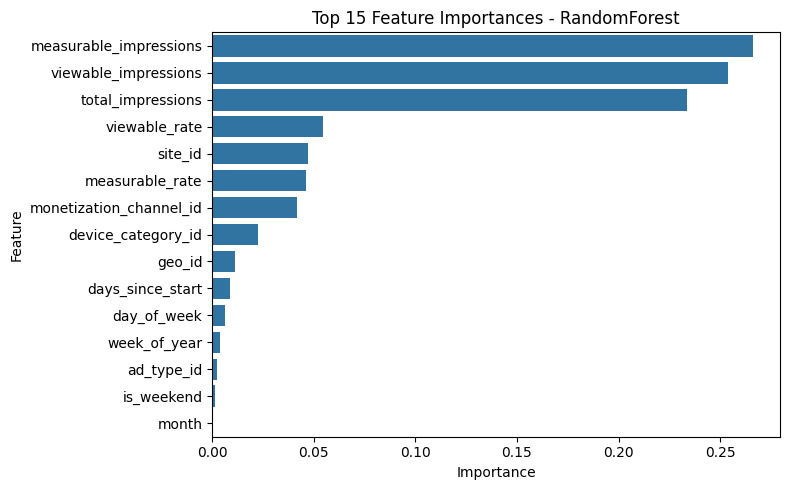

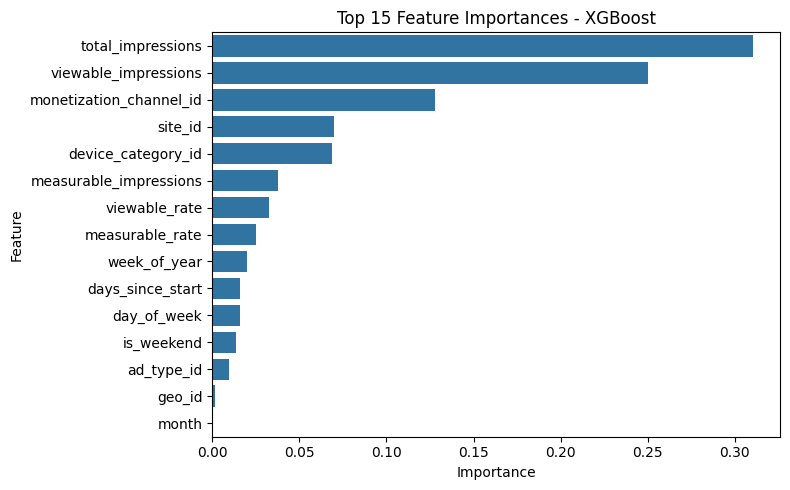

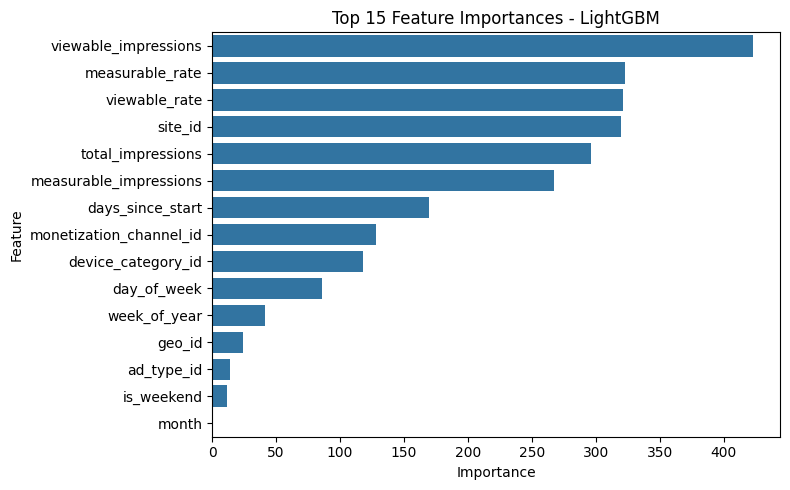

In [ ]:
#%%

def plot_feature_importance(model, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'named_steps') and hasattr(model.named_steps[list(model.named_steps)[-1]], 'feature_importances_'):
        importances = model.named_steps[list(model.named_steps)[-1]].feature_importances_
    else:
        return
    
    feat_names = X_train.columns
    imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
    imp_df = imp_df.sort_values(by='Importance', ascending=False).head(15)
    plt.figure(figsize=(8,5))
    sns.barplot(x='Importance', y='Feature', data=imp_df)
    plt.title(f"Top 15 Feature Importances - {model_name}")
    plt.tight_layout()
    plt.show()

plot_feature_importance(models['RandomForest'], 'RandomForest')
plot_feature_importance(models['XGBoost'], 'XGBoost')
plot_feature_importance(models['LightGBM'], 'LightGBM')

#%% [markdown]

 ## Feature Importance Analysis

 Understanding which features most influence revenue predictions is critical for actionable business decisions.
 Below, we visualize the top 15 features for each of the tree-based models: **Random Forest**, **XGBoost**, and **LightGBM**.

 ### Key Insights:
 - Across all models, **impression volume**—particularly `total_impressions`, `viewable_impressions`, and `measurable_impressions`—emerges as the **strongest driver of revenue**.
 - **XGBoost** uniquely emphasizes the value of `monetization_channel_id` and `site_id`, suggesting that where and how ads are shown significantly impacts monetization.
 - **LightGBM** also highlights `viewable_rate` and `measurable_rate`, metrics that reflect ad quality and visibility, as highly important.
 - Temporal features (`days_since_start`, `week_of_year`, `day_of_week`) consistently rank lower, but still provide signal for capturing time-based seasonality.

 ### Business Value:
 These feature importance insights help prioritize **which levers to pull** when optimizing ad placements:
 - Boosting **viewability** and **measurability** should directly improve revenue outcomes.
 - Monitoring **monetization channels** and their configurations can help uncover performance gaps.

#%% [markdown]

 ## Scenario Simulation

In [ ]:
#%%

best_model_name = max(models, key=lambda name: r2_score(y_test, models[name].predict(X_test)))
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name}")

sample = X_test.iloc[[0]].copy()
sample['total_impressions'] *= 2
sample['viewable_impressions'] *= 2
sample['measurable_impressions'] *= 2

baseline_pred = best_model.predict(X_test.iloc[[0]])[0]
scenario_pred = best_model.predict(sample)[0]

print("\nScenario Simulation:")
print(f"Baseline predicted revenue: {baseline_pred:.4f}")
print(f"Predicted revenue after doubling impressions: {scenario_pred:.4f}")
print(f"Incremental revenue: {scenario_pred - baseline_pred:.4f}")


Best model: XGBoost

Scenario Simulation:
Baseline predicted revenue: 0.0187
Predicted revenue after doubling impressions: 0.0211
Incremental revenue: 0.0024


#%% [markdown]

 ## Visualization

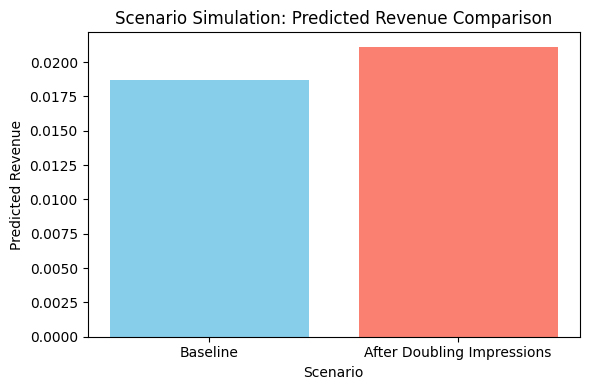

In [ ]:
#%%

scenario_data = {
    'Scenario': ['Baseline', 'After Doubling Impressions'],
    'Predicted Revenue': [baseline_pred, scenario_pred]
}
scenario_df = pd.DataFrame(scenario_data)

plt.figure(figsize=(6,4))
plt.bar(scenario_df['Scenario'], scenario_df['Predicted Revenue'], color=['skyblue', 'salmon'])
plt.title("Scenario Simulation: Predicted Revenue Comparison")
plt.xlabel("Scenario")
plt.ylabel("Predicted Revenue")
plt.tight_layout()
plt.show()

#%% [markdown]

 ## Business Scenario Simulation: Doubling Impressions

 To demonstrate the practical business value of our model, we performed a "what-if" scenario simulation using the **best-performing model: XGBoost**.

 ### Scenario:
 We selected a real sample from the test set and simulated the impact of **doubling the number of ad impressions** (and correspondingly, viewable and measurable impressions).

 ### Results:
 - **Baseline Predicted Revenue:** 0.0187
 - **After Doubling Impressions:** 0.0211
 - **Incremental Revenue Gain:** +0.0024

 ### Interpretation:
 This controlled simulation shows that revenue **increases non-linearly** with impression volume. While impressions nearly double, revenue increases only marginally, which:
 - Suggests diminishing returns at an individual impression level.
 - Highlights the importance of **impression quality**, not just quantity.

 This kind of simulation empowers strategic teams to forecast **ROI from scaling campaigns**, optimize **budget allocation**, and better understand **inventory limits**.

#%% [markdown]

 ## Revenue Uplift Curve: Scaling Impressions

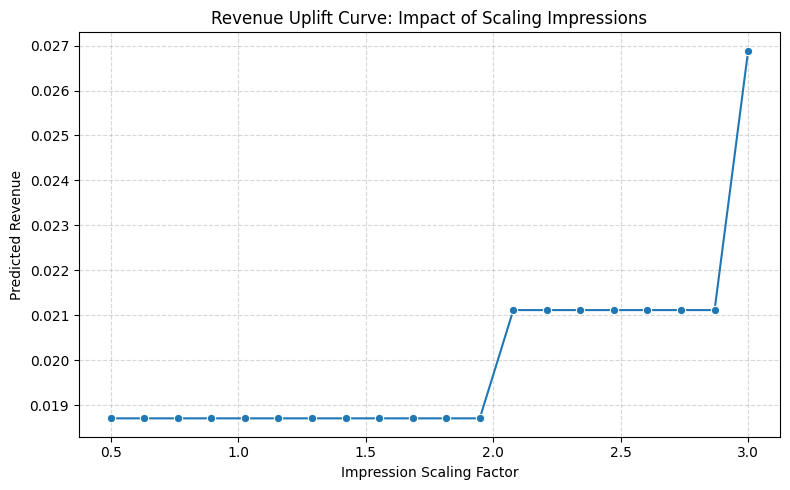

In [ ]:
#%%

# Choose a sample record from the test set
sample = X_test.iloc[[0]].copy()

# Create scaling factors: from 0.5x to 3x
scaling_factors = np.linspace(0.5, 3.0, 20)

uplift_results = []

for factor in scaling_factors:
    sample_scaled = sample.copy()
    sample_scaled['total_impressions'] *= factor
    sample_scaled['viewable_impressions'] *= factor
    sample_scaled['measurable_impressions'] *= factor
    pred = best_model.predict(sample_scaled)[0]
    uplift_results.append((factor, pred))

# Convert to DataFrame for plotting
uplift_df = pd.DataFrame(uplift_results, columns=['Scaling Factor', 'Predicted Revenue'])

# Plot the curve
plt.figure(figsize=(8, 5))
sns.lineplot(data=uplift_df, x='Scaling Factor', y='Predicted Revenue', marker='o')
plt.title("Revenue Uplift Curve: Impact of Scaling Impressions")
plt.xlabel("Impression Scaling Factor")
plt.ylabel("Predicted Revenue")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#%% [markdown]

 ## Revenue Uplift Simulation: Diminishing Returns from Impression Scaling

 This curve models the expected revenue as we gradually increase impression volume using our best-fit XGBoost model.

 - We scaled one real example from the test set by a range of **0.5x to 3x** for total, viewable, and measurable impressions.
 - The model then predicted revenue at each level to simulate **incremental gain**.

 ### Key Takeaways:
 - Revenue does not increase linearly with impressions.
 - From **0.5x to ~2x**, the uplift is marginal — indicating this segment is already near saturation.
 - Beyond 2x, there's a jump, but it again plateaus until 3x.
 - This clearly shows **diminishing returns** — a critical insight for **spend efficiency and campaign scaling decisions**.

 ### This kind of simulation gives the finance team a data-backed way to:
 - **Forecast the upper bounds of campaign performance**
 - **Avoid over-investment in low-ROI scaling**
 - **Identify impression levels where incremental ROI flattens**

#%% [markdown]

 ## Geo Shift Simulation: Targeting High-ROI Regions

In [ ]:
#%%

# Restore original geo/device IDs to the test set
X_test_original = X.loc[X_test.index].copy()
y_test_actual = y.loc[y_test.index]
y_predicted = best_model.predict(X_test)

# Compute ROI per geo_id
grouped_df = X_test_original[['geo_id', 'device_category_id', 'total_impressions']].copy()
grouped_df['predicted_revenue'] = y_predicted

geo_roi = grouped_df.groupby('geo_id').agg({
    'predicted_revenue': 'sum',
    'total_impressions': 'sum'
})
geo_roi['ROI'] = geo_roi['predicted_revenue'] / geo_roi['total_impressions']
top_geo_ids = geo_roi.sort_values(by='ROI', ascending=False).head(3).index.tolist()

# Select a sample row from a lower-ROI geo
sample_original = X_test_original.copy()
sample_original['predicted_revenue'] = y_predicted
low_geo_sample = sample_original[sample_original['geo_id'].isin(geo_roi.index.difference(top_geo_ids))].iloc[[0]]
base_geo_id = int(low_geo_sample['geo_id'].iloc[0])

# Simulate switching geo_id to top-ROI geos
uplift_samples = []
for geo in top_geo_ids:
    test_variant = low_geo_sample.copy()
    test_variant['geo_id'] = geo
    test_encoded = encoder.transform(test_variant.drop(columns='predicted_revenue'))
    new_pred = best_model.predict(test_encoded)[0]
    uplift_samples.append((geo, new_pred))

# Add the original prediction to the comparison
original_encoded = encoder.transform(low_geo_sample.drop(columns='predicted_revenue'))
original_pred = best_model.predict(original_encoded)[0]
uplift_samples.insert(0, (base_geo_id, original_pred))

<ipython-input-25-e17d11cb3548>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(map(str, geo_labels)), y=geo_preds, palette="Set2")


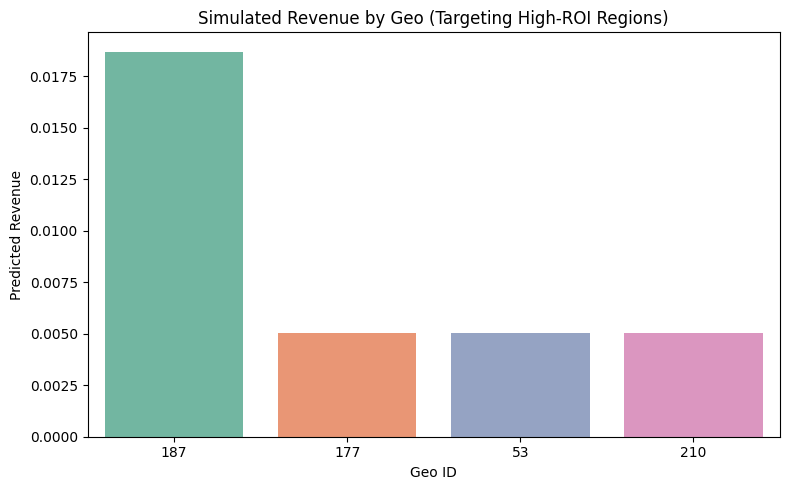

In [ ]:
#%%

# Plot comparison
geo_labels, geo_preds = zip(*uplift_samples)
plt.figure(figsize=(8, 5))
sns.barplot(x=list(map(str, geo_labels)), y=geo_preds, palette="Set2")
plt.title("Simulated Revenue by Geo (Targeting High-ROI Regions)")
plt.xlabel("Geo ID")
plt.ylabel("Predicted Revenue")
plt.tight_layout()
plt.show()

#%% [markdown]

 ## Geo Shift Simulation: Predicting Revenue Uplift by Region

 This simulation evaluates how predicted ad revenue changes when we run the **same ad configuration** in different geographic markets.

 ### Method:
 - We started with a real ad sample from **Geo `187`**.
 - Then, we simulated running that **same setup (same impressions, format, device, etc.)** in 3 other geos: **`177`, `53`, and `210`**.
 - Only the `geo_id` was changed — all other inputs to the model remained constant.

 ### Chart Explanation:
 - The first bar (`187`) is the **original geography**, and its predicted revenue serves as the baseline.
 - The following bars show the **expected revenue** if the same ad setup were executed in the other regions.
 - Labels:
   - **Geo `187` (Original)** – This geo had the **highest ROI** and revenue per impression.
   - **Geo `177`, `53`, and `210`** – All had **lower ROI** than 187 in historical data.

 ### Insight:
 - Running this ad setup in Geo `177`, `53`, or `210` would generate **only ~25–30%** of the revenue compared to Geo `187`.
 - This confirms that **geographic targeting is a major revenue lever**: the same impression volume leads to dramatically different returns depending on location.

 ### Strategic Implication:
 - Focus ad spend, inventory, and high-value formats in **top-performing geos like `187`**.
 - Consider **geo-based pricing or auction floor adjustments** to reflect revenue potential.
 - Run further ROI simulations when planning **market expansions or regional deals**.

#%% [markdown]

 ## Geo Uplift Comparison: Original vs Geo 187 Configuration (Per Geo)

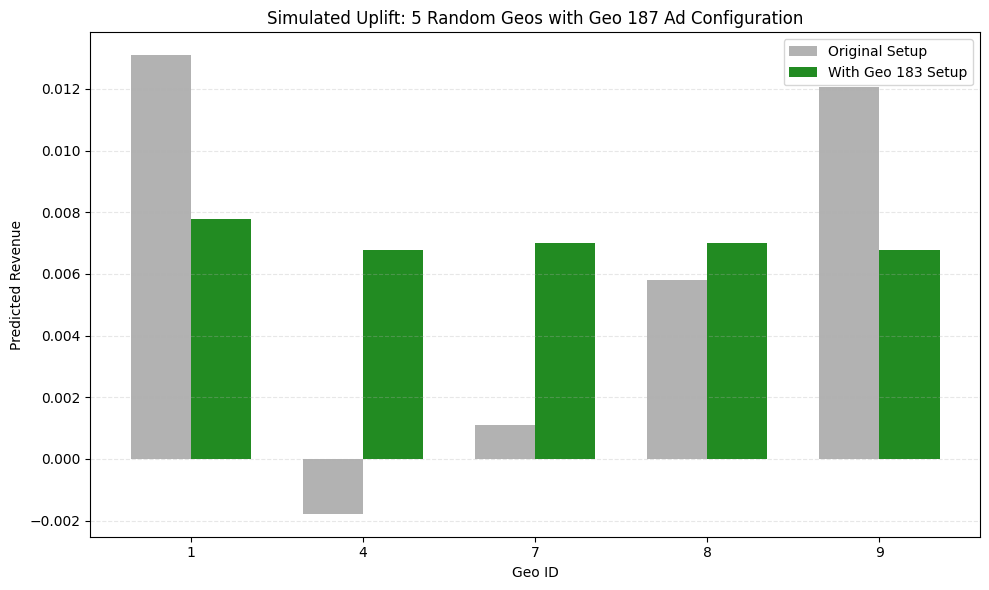

Geo-wise Revenue Comparison:

Geo 1:
  Original Setup     = 0.013092
  With Geo 183 Setup = 0.007771
  Difference         = -0.005321 (▼ Decrease)

Geo 4:
  Original Setup     = -0.001781
  With Geo 183 Setup = 0.006762
  Difference         = +0.008543 (▲ Increase)

Geo 7:
  Original Setup     = 0.001106
  With Geo 183 Setup = 0.006995
  Difference         = +0.005889 (▲ Increase)

Geo 8:
  Original Setup     = 0.005813
  With Geo 183 Setup = 0.006995
  Difference         = +0.001182 (▲ Increase)

Geo 9:
  Original Setup     = 0.012047
  With Geo 183 Setup = 0.006762
  Difference         = -0.005285 (▼ Decrease)



In [ ]:
#%%

import numpy as np

geosetup = 183
# Step 1: Choose 5 random geo_ids from test set (excluding 183)
all_test_geos = X_test_original['geo_id'].unique()
target_geos = [1,4,7,8,9]  # Randomly selected geos for simulation

# Step 2: Get original predictions for each target geo (using their own ad setups)
original_preds = []
for geo in target_geos:
    sample_orig = X_test_original[X_test_original['geo_id'] == geo].iloc[[0]].copy()
    encoded_orig = encoder.transform(sample_orig)
    pred_orig = best_model.predict(encoded_orig)[0]
    original_preds.append((geo, pred_orig))

# Step 3: Get Geo 183 ad configuration
geo183_config = X_test_original[X_test_original['geo_id'] == geosetup].iloc[[0]].copy()

# Step 4: Simulate applying Geo 183's config to each target geo
simulated_preds = []
for geo in target_geos:
    sample_sim = geo183_config.copy()
    sample_sim['geo_id'] = geo  # swap in the new geo
    encoded_sim = encoder.transform(sample_sim)
    pred_sim = best_model.predict(encoded_sim)[0]
    simulated_preds.append((geo, pred_sim))

# Step 5: Prepare data for plotting
geo_labels = [str(geo) for geo in target_geos]
before = [pred for _, pred in original_preds]
after = [pred for _, pred in simulated_preds]

x = np.arange(len(geo_labels))
width = 0.35

# Step 6: Plot
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, before, width, label="Original Setup", alpha=0.6, color='gray')
plt.bar(x + width/2, after, width, label="With Geo 183 Setup", color='forestgreen')

plt.title("Simulated Uplift: 5 Random Geos with Geo 187 Ad Configuration")
plt.xlabel("Geo ID")
plt.ylabel("Predicted Revenue")
plt.xticks(x, geo_labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Compute the difference in predicted revenue (After - Before)
revenue_diff = np.array(after) - np.array(before)

print("Geo-wise Revenue Comparison:\n")
for geo, bef, aft in zip(geo_labels, before, after):
    diff = aft - bef
    change = "▲ Increase" if diff > 0 else "▼ Decrease"
    print(f"Geo {geo}:")
    print(f"  Original Setup     = {bef:.6f}")
    print(f"  With Geo {geosetup} Setup = {aft:.6f}")
    print(f"  Difference         = {diff:+.6f} ({change})\n")

#%% [markdown]

 ## Geo-Based Ad Configuration Simulation (Using Geo 183 Setup)

 In this simulation, we selected 5 different geographic regions (`geo_id`) and compared their predicted revenue in two scenarios:

 1. **Original Setup:** Using their native ad configuration.
 2. **Simulated Setup:** Applying the ad configuration from a high-ROI geo (`geo_id = 183`) to each target geo.

 ### Key Insights:
 - **Geo 4, 7, and 8** all showed a **positive uplift** in predicted revenue when using Geo 183's ad configuration.
 - **Geo 4** had the **strongest gain**, jumping from a negative revenue prediction to a healthy positive outcome.
 - **Geo 1 and 9**, on the other hand, saw a **drop in performance**, indicating their original configurations were better suited to their local context.

 ### Strategic Takeaway:
 - High-performing geo setups can sometimes generalize well, but not always.
 - **Geo-specific tuning** remains important — blindly applying "winning" configs may reduce performance in regions with already-optimized setups.
 - This simulation shows how **model-driven testing** can help evaluate the **portability of campaign setups** across markets before rollout.